In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 4986.24it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][8084]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

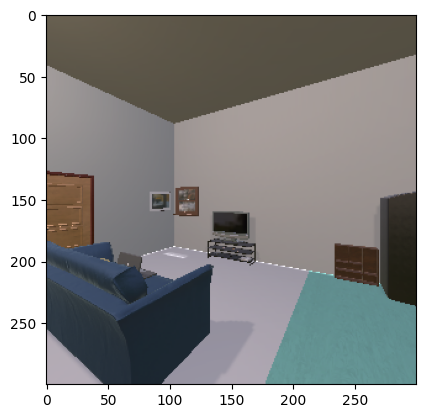

In [136]:
import matplotlib.pyplot as plt
event = controller.step("MoveAhead")
plt.imshow(event.frame)

In [4]:
event.metadata["agent"]["position"]

{'x': 3.5, 'y': 0.9009997844696045, 'z': 5.0}

In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty, load_actor_critic
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [6]:
# After loading the scene and stepping once:
event = controller.step("Pass")

# Extract bounding box
bounds_meta = event.metadata.get("sceneBounds", None)
if bounds_meta is None:
    raise KeyError("sceneBounds metadata not found")

center = bounds_meta["center"]
size   = bounds_meta["size"]

xmin = center["x"] - size["x"] / 2
xmax = center["x"] + size["x"] / 2
zmin = center["z"] - size["z"] / 2
zmax = center["z"] + size["z"] / 2

x_center = center["x"]
z_center = center["z"]
house_size = max(size["x"], size["z"]) / 2   # or size["x"]/2 if you want

In [7]:
event = controller.step(
    action="AddThirdPartyCamera",
    position={"x": x_center, "y": 20.0, "z": z_center},
    rotation={"x": 90.0, "y": 0.0, "z": 0.0},
    orthographic=True,
    orthographicSize=house_size,
    fieldOfView=60,
    skyboxColor="black"
)

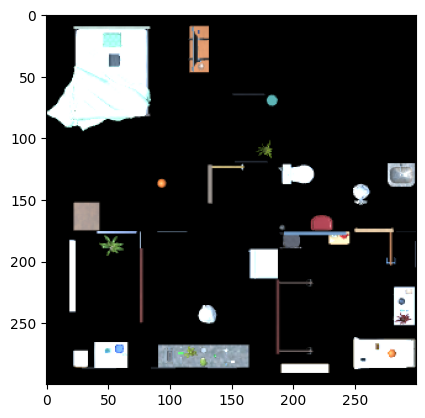

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
topdown = event.third_party_camera_frames[0]
plt.imshow(topdown)

In [8]:
from models import FrozenResNetPCAEncoder
import torch
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetPCAEncoder(FEAT_DIM, torch.zeros(FEAT_DIM, 512), device=DEVICE)
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)

In [9]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic, "data/segment_novelty/segment_novelty_8084_39.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/segment_novelty/segment_novelty_8084_39.pt


In [12]:
from rl import PPO, inference, inference_video_mp4, teleport
import torch

def get_distributions(ppo: PPO, obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    print(dist.probs)
    return dist


def get_trajectory(controller, position):
    event = controller.step("Pass")
    # Load the topdown image
    topdown = event.third_party_camera_frames[0]
    H, W = topdown.shape[0], topdown.shape[1]

    # positions is List[(x,z)]
    pos = np.array(position)  # shape (T, 2)
    xs = pos[:,0]
    zs = pos[:,1]

    # Convert meters -> pixels
    img_x = (xs - (x_center - house_size)) * (W / (2 * house_size))
    img_y = (zs - (z_center - house_size)) * (H / (2 * house_size))
    img_y = H - img_y
    return topdown, img_x, img_y

# points = {
#     "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
#     "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
#     "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
# }

# for name, point in points.items():
#     position = inference_video_mp4(get_distributions, controller, ppo=PPO(0.08), init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}.mp4")
#     topdown, img_x, img_y = get_trajectory(controller, position)

#     plt.figure(figsize=(8,8))
#     plt.imshow(topdown)
#     plt.plot(img_x, img_y, color="blue", linewidth=2)
#     plt.scatter(img_x[0], img_y[0], color="green", label="Start")
#     plt.scatter(img_x[-1], img_y[-1], color="blue", label="End")
#     plt.legend()
#     plt.axis("off")
#     plt.savefig(f"rollout{name}.png", bbox_inches='tight', pad_inches=0.1)
#     plt.show()

In [90]:
from ai2thor.controller import Controller


house = dataset["train"][8084]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]


{'x': 0.75, 'y': 0.9009993672370911, 'z': 4.75}


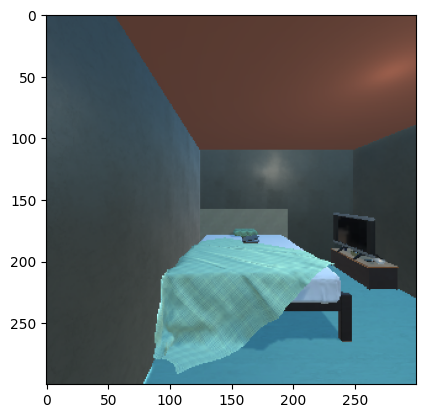

In [94]:
event = teleport(controller)
print(event.metadata["agent"]["position"])
plt.imshow(event.frame)

In [95]:
event = controller.step(
    action="AddThirdPartyCamera",
    position={"x": x_center, "y": 20.0, "z": z_center},
    rotation={"x": 90.0, "y": 0.0, "z": 0.0},
    orthographic=True,
    orthographicSize=house_size,
    fieldOfView=60,
    skyboxColor="black"
)

In [52]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetPCAEncoder(FEAT_DIM, torch.zeros(FEAT_DIM, 512), device=DEVICE)
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [53]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic, "data/pca_resnet/pca_resnet_fine_tune_8084.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/pca_resnet/pca_resnet_fine_tune_8084.pt


tensor([0.3681, 0.3297, 0.3022])
tensor([0.3727, 0.3589, 0.2684])
tensor([0.3006, 0.4134, 0.2861])
tensor([0.3003, 0.3090, 0.3907])
tensor([0.1938, 0.5291, 0.2770])
tensor([0.1414, 0.5122, 0.3464])
tensor([0.1941, 0.4602, 0.3458])
tensor([0.0960, 0.6457, 0.2583])
tensor([0.1603, 0.5310, 0.3087])
tensor([0.2226, 0.4758, 0.3016])
tensor([0.3688, 0.2447, 0.3865])
tensor([0.1918, 0.5482, 0.2601])
tensor([0.4641, 0.3355, 0.2003])
tensor([0.2832, 0.5353, 0.1815])
tensor([0.2790, 0.1726, 0.5484])
tensor([0.1470, 0.3843, 0.4687])
tensor([0.3054, 0.2151, 0.4795])
tensor([0.2998, 0.2370, 0.4632])
tensor([0.2863, 0.2268, 0.4869])
tensor([0.1671, 0.3820, 0.4509])
tensor([0.1071, 0.5814, 0.3115])
tensor([0.1849, 0.4521, 0.3630])
tensor([0.1534, 0.5804, 0.2662])
tensor([0.3863, 0.2049, 0.4087])
tensor([0.2233, 0.4782, 0.2985])
tensor([0.1688, 0.5573, 0.2739])
tensor([0.1314, 0.6114, 0.2572])
tensor([0.1747, 0.5082, 0.3171])
tensor([0.3862, 0.2950, 0.3188])
tensor([0.1757, 0.5700, 0.2543])
tensor([0.

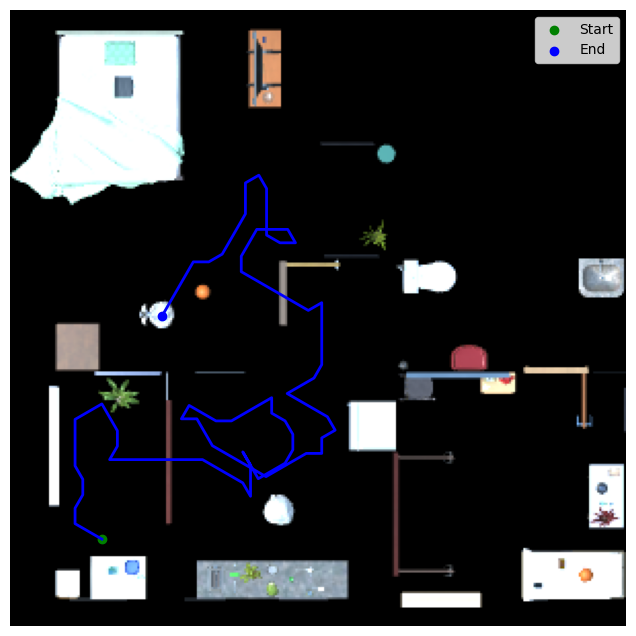

tensor([0.2829, 0.3072, 0.4100])
tensor([0.2785, 0.2351, 0.4864])
tensor([0.4470, 0.3160, 0.2370])
tensor([0.2708, 0.3185, 0.4107])
tensor([0.2344, 0.4856, 0.2800])
tensor([0.2876, 0.4216, 0.2907])
tensor([0.2304, 0.4653, 0.3042])
tensor([0.2501, 0.3301, 0.4198])
tensor([0.2793, 0.3671, 0.3535])
tensor([0.2260, 0.5619, 0.2121])
tensor([0.2645, 0.3617, 0.3738])
tensor([0.1881, 0.5225, 0.2893])
tensor([0.2480, 0.3121, 0.4398])
tensor([0.2378, 0.4058, 0.3565])
tensor([0.1506, 0.4412, 0.4081])
tensor([0.2169, 0.3550, 0.4280])
tensor([0.1481, 0.3868, 0.4652])
tensor([0.1487, 0.3983, 0.4530])
tensor([0.1912, 0.3410, 0.4679])
tensor([0.1697, 0.4208, 0.4096])
tensor([0.1684, 0.4275, 0.4040])
tensor([0.1353, 0.3155, 0.5492])
tensor([0.1405, 0.3036, 0.5559])
tensor([0.1534, 0.4059, 0.4406])
tensor([0.1356, 0.2770, 0.5874])
tensor([0.1546, 0.3747, 0.4707])
tensor([0.2076, 0.3631, 0.4293])
tensor([0.1678, 0.2910, 0.5412])
tensor([0.1240, 0.3983, 0.4777])
tensor([0.1213, 0.4262, 0.4525])
tensor([0.

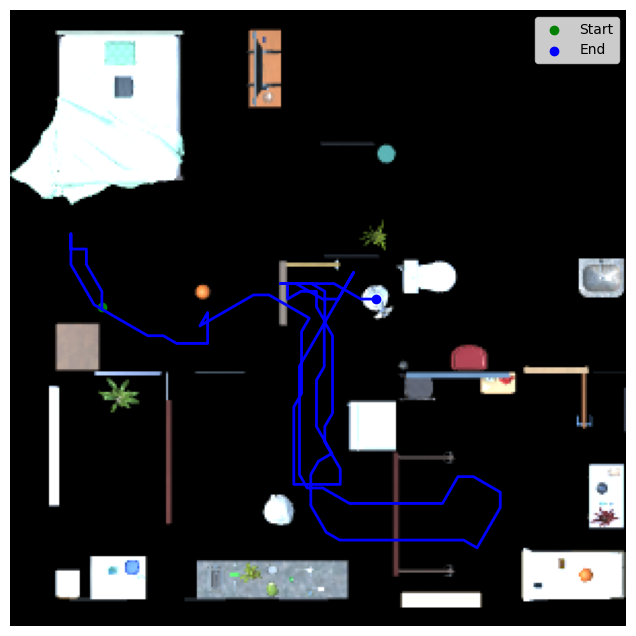

tensor([0.0956, 0.7083, 0.1961])
tensor([0.1204, 0.5696, 0.3101])
tensor([0.0913, 0.6791, 0.2295])
tensor([0.1104, 0.6893, 0.2003])
tensor([0.1103, 0.6719, 0.2178])
tensor([0.1504, 0.5305, 0.3191])
tensor([0.1756, 0.4571, 0.3674])
tensor([0.1557, 0.5129, 0.3313])
tensor([0.1272, 0.6135, 0.2593])
tensor([0.1497, 0.4935, 0.3568])
tensor([0.1375, 0.5305, 0.3320])
tensor([0.1819, 0.4526, 0.3656])
tensor([0.1250, 0.4930, 0.3820])
tensor([0.4269, 0.3989, 0.1742])
tensor([0.2278, 0.3430, 0.4292])
tensor([0.2042, 0.3489, 0.4469])
tensor([0.1571, 0.3185, 0.5244])
tensor([0.1087, 0.3414, 0.5499])
tensor([0.1959, 0.4494, 0.3547])
tensor([0.1194, 0.2988, 0.5818])
tensor([0.1535, 0.4396, 0.4069])
tensor([0.1817, 0.3724, 0.4460])
tensor([0.1255, 0.2528, 0.6216])
tensor([0.1609, 0.4785, 0.3606])
tensor([0.1244, 0.2502, 0.6254])
tensor([0.1786, 0.3979, 0.4235])
tensor([0.2224, 0.3962, 0.3814])
tensor([0.1124, 0.3580, 0.5296])
tensor([0.1624, 0.1809, 0.6567])
tensor([0.2733, 0.1691, 0.5576])
tensor([0.

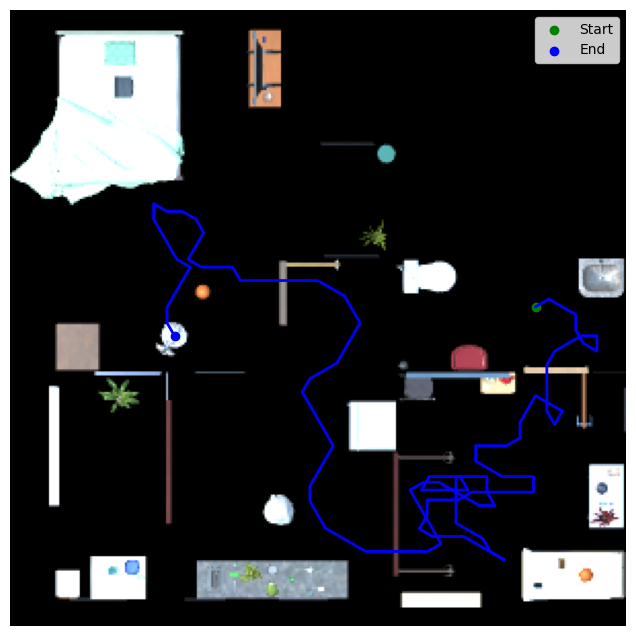

In [16]:
import numpy as np
import matplotlib.pyplot as plt
points = {
    "center_point": {'x': 0.75, 'y': 0.9009993672370911, 'z': 1.0},
    "inside_bedroom": {'x': 0.75, 'y': 0.9009993672370911, 'z': 4.75},
    "inside_toilet": {'x': 7.75, 'y': 0.9009997844696045, 'z': 4.75},
}

for name, point in points.items():
    position = inference_video_mp4(get_distributions, controller, ppo=PPO(0.08), init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}.mp4")
    topdown, img_x, img_y = get_trajectory(controller, position)

    plt.figure(figsize=(8,8))
    plt.imshow(topdown)
    plt.plot(img_x, img_y, color="blue", linewidth=2)
    plt.scatter(img_x[0], img_y[0], color="green", label="Start")
    plt.scatter(img_x[-1], img_y[-1], color="blue", label="End")
    plt.legend()
    plt.axis("off")
    plt.savefig(f"rollout{name}.png", bbox_inches='tight', pad_inches=0.1)
    plt.show()